In [3]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

### Registration of regions of interest (ROIs) to common space

The ROIs of this study are the following:

| Hemisphere | Region | Abbreviation | Origin |   
| :--- |: --- :| --- | --- |   
| L&R | Striatum | STR | ATAG Healthy Young |   
| L&R | Subthalamic nucleus | STN | ATAG Healthy Young |   
| L&R | Globus Pallidus interna | GPi | ATAG Healthy Young |   
| L&R | Globus Pallidus externa | GPe | ATAG Healthy Young |   
| L&R | Pre-supplementary motor area | PreSMA | Boekel et al. (2017); originally from  Johansen-Berg et al. (2004) |   
| R | Inferior frontal gyrus | rIFG | Harvard-Oxford cortical atlas |   
| - | Anterior Cingulate Cortex | ACC | Harvard-Oxford cortical atlas |   
| L&R | Primary motor cortex | M1 | Harvard-Oxford cortical atlas |   

----


This notebook warps all masks to MNI2009a and MNI2009c-space, following `BEP011` https://docs.google.com/document/d/1YG2g4UkEio4t_STIBOqYOwneLEs1emHIXbGKynx7V0Y/edit#

###### References:
Boekel, Forstmann, Keuken (2017). A test-retest reliability analysis of diffusion measures of white matter tracts relevant for cognitive control. Psychophysiology, 54, 24-33.

Johansen-Berg, H., Behrens, T., Robson, M. D., Drobnjak, I., Rushworth, M., Brady, J. M., . . . Matthews, P. M. (2004). Changes in connectivity profiles define functionally distinct regions in human medial frontal cortex. Pro- ceedings of the National Academy of Sciences of the United States of America, 101(36), 13335–13340. doi: 10.1073/pnas.0403743101

Keuken, M. C., Bazin, P.-L., Crown, L., Hootsmans, J., Laufer, A., M€uller- Axt, C., . . . Forstmann, B. U. (2014). Quantifying inter-individual ana- tomical variability in the subcortex using 7T structural MRI. Neuro- Image, 94(1), 40–46. doi: 10.1016/j.neuroimage.2014.03.032

In [33]:
# util functions
def add_contours(disp, roi, thr=0.3, **kwargs):
    from nilearn._utils.extmath import fast_abs_percentile
    from nilearn._utils.param_validation import check_threshold
    map_img = nib.load(roi)
    data = map_img.get_data()
    thr = check_threshold(thr, data,
                      percentile_func=fast_abs_percentile,
                      name='threshold')
    # Get rid of background values in all cases
    thr = max(thr, 1e-6)
    disp.add_contours(roi, levels=[thr], **kwargs)
    


In [166]:
import nighres
import os
import nibabel as nib
import numpy as np
from nighres.registration import embedded_antsreg, apply_coordinate_mappings
from nilearn import plotting
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
template_dir = '/home/stevenm/Templates/'

## All anatomicl images to register
mni05_brain = os.path.join(template_dir, 'MNI05_standard/standard/MNI152_T1_1mm_brain.nii.gz')  # 1 mm
mni05_brain_p4mm = './masks/orig_Boekel_et_al/MNI152_T1_04mm_brain.nii.gz'  # 0.4 mm
mni09a_brain = os.path.join(template_dir, 'mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm.nii.gz') # 09a 1mm

mni09c = os.path.join(template_dir, 'mni_icbm152_nlin_asym_09c_nifti', 'mni_icbm152_nlin_asym_09c', 'mni_icbm152_t1_tal_nlin_asym_09c.nii')
mni09c_brain_mask = os.path.join(template_dir, 'mni_icbm152_nlin_asym_09c_nifti', 'mni_icbm152_nlin_asym_09c', 'mni_icbm152_t1_tal_nlin_asym_09c_mask.nii')

def mask_and_save(img, mask):
    img_hdr = nib.load(img)
    mask_hdr = nib.load(mask)
    
    img_data = img_hdr.get_data()
    mask_data = mask_hdr.get_data()
    
    img_data[mask_data.astype(bool)==False] = 0
    
    img_nii = nib.Nifti1Image(img_data, img_hdr.affine)
    nib.save(img_nii, img.replace('.nii', '_brain.nii'))
    
    return img.replace('.nii', '_brain.nii')

mni09c_brain = mask_and_save(mni09c, mni09c_brain_mask)

registration_dir = './masks/registration'
if not os.path.exists(registration_dir):
    os.makedirs(registration_dir)

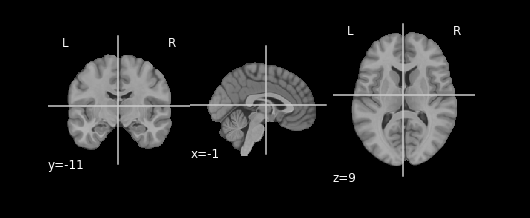

In [10]:
plotting.plot_anat(mni09c_brain)

In [11]:
# utility function to checkout registration results
def make_report(fixed_image, moving_image, output_dir=os.getcwd(), fn='report.svg',
               compress_report=False):
    from nipype.interfaces.base import File
    _fixed_image = fixed_image
    _moving_image = moving_image
    _fixed_image_mask = None
    _fixed_image_label = "fixed"
    _moving_image_label = "moving"
    _contour = None
    #    _out_report = File('report.svg', usedefault=True, desc='filename for the visual report')#'report.svg'
    _out_report = os.path.abspath(os.path.join(output_dir, fn))

    from niworkflows.viz.utils import plot_registration, compose_view, cuts_from_bbox
    from nilearn.masking import apply_mask, unmask
    from nilearn.image import threshold_img, load_img

    fixed_image_nii = load_img(_fixed_image)  # template
    moving_image_nii = load_img(_moving_image)  # source
    contour_nii = load_img(_contour) if _contour is not None else None

    if _fixed_image_mask:
        fixed_image_nii = unmask(apply_mask(fixed_image_nii,
                                            _fixed_image_mask),
                                 _fixed_image_mask)
        # since the moving image is already in the fixed image space we
        # should apply the same mask
        moving_image_nii = unmask(apply_mask(moving_image_nii,
                                             _fixed_image_mask),
                                  _fixed_image_mask)
        mask_nii = load_img(_fixed_image_mask)
    else:
        mask_nii = threshold_img(fixed_image_nii, 1e-3)

    n_cuts = 7
    if not _fixed_image_mask and contour_nii:
        cuts = cuts_from_bbox(contour_nii, cuts=n_cuts)
    else:
        cuts = cuts_from_bbox(mask_nii, cuts=n_cuts)

    # Call composer
    compose_view(
        plot_registration(fixed_image_nii, 'fixed-image',
                          estimate_brightness=True,
                          cuts=cuts,
                          label=_fixed_image_label,
                          contour=contour_nii,
                          compress=compress_report),
        plot_registration(moving_image_nii, 'moving-image',
                          estimate_brightness=True,
                          cuts=cuts,
                          label=_moving_image_label,
                          contour=contour_nii,
                          compress=compress_report),
        out_file=_out_report
    )
    return _out_report

## Calculate warps
1. MNI05 -> MNI09c
2. MNI05 p4mm -> MNI05 1mm

In [15]:
### Register MNI05 1mm to MNI09c (syn)
syn_res = embedded_antsreg(source_image=mni05_brain,
                           target_image=mni09c_brain,
                           output_dir=registration_dir,
                           file_name='mni05_to_mni09c',
                           save_data=True, 
                           overwrite=False)


Embedded ANTs Registration

Outputs will be saved to ./masks/registration/

Saving ./masks/registration/mni05_to_mni09c_tmp_srccoord.nii.gz

Saving ./masks/registration/mni05_to_mni09c_tmp_trgcoord.nii.gz
registering /home/stevenm/Templates/MNI05_standard/standard/MNI152_T1_1mm_brain.nii.gz
 to /home/stevenm/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii
antsRegistration --collapse-output-transforms 1 --dimensionality 3 --initialize-transforms-per-stage 0 --interpolation Linear --output mni05_to_mni09c_tmp_syn --transform Rigid[ 0.1 ] --metric MI[ /home/stevenm/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii, /home/stevenm/Templates/MNI05_standard/standard/MNI152_T1_1mm_brain.nii.gz, 1, 32, Random, 0.3 ] --convergence [ 1000x1000x1000, 1e-06, 10 ] --smoothing-sigmas 3.0x2.0x1.0 --shrink-factors 4x2x1 --use-histogram-matching 0 --transform SyN[ 0.2, 4.0, 3.0 ] 

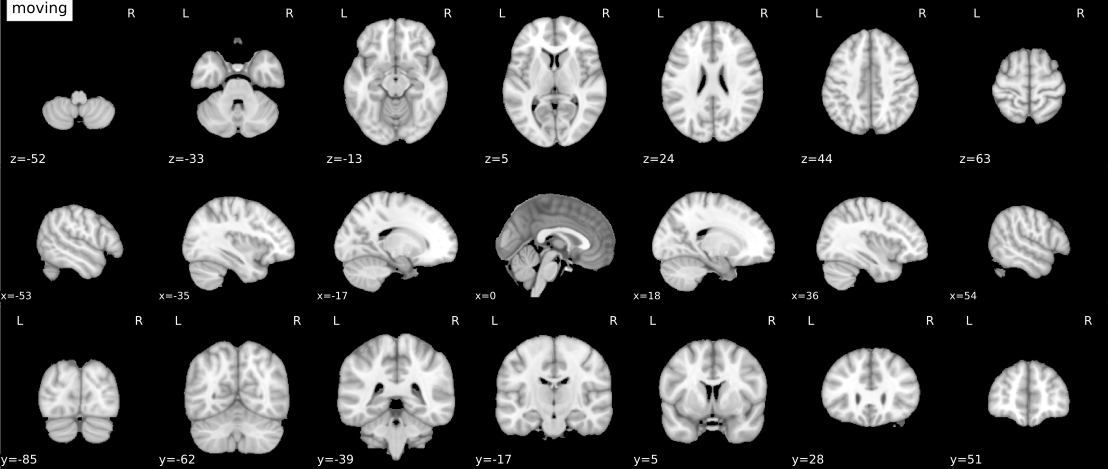

In [18]:
### Checkout registration quality
mni05_1mm_2_mni09c_svg = make_report(fixed_image=mni09c_brain, moving_image=syn_res['transformed_source'],
                                     output_dir=registration_dir, fn='mni05_1mm_2_mni09c.svg')
from IPython.display import SVG, display
display(SVG(mni05_1mm_2_mni09c_svg))

Not so much wrong with this

In [19]:
### Register MNI05 0.4mm to MNI05 1.0mm (rigid)
### Simply set all iterations to 0 to apply the affine. It's already in the same space (just not the same voxel dims)
syn_res2 = embedded_antsreg(source_image=mni05_brain_p4mm,
                            target_image=mni05_brain,
                            run_syn=False, run_affine=False,
                            rigid_iterations=0,
                            file_name='mni05_0p4_to_mni05_1p0',
                            output_dir=registration_dir, save_data=True, overwrite=False)


Embedded ANTs Registration

Outputs will be saved to ./masks/registration/

Saving ./masks/registration/mni05_0p4_to_mni05_1p0_tmp_srccoord.nii.gz

Saving ./masks/registration/mni05_0p4_to_mni05_1p0_tmp_trgcoord.nii.gz
registering ./masks/orig_Boekel_et_al/MNI152_T1_04mm_brain.nii.gz
 to /home/stevenm/Templates/MNI05_standard/standard/MNI152_T1_1mm_brain.nii.gz
antsRegistration --collapse-output-transforms 1 --dimensionality 3 --initialize-transforms-per-stage 0 --interpolation Linear --output mni05_0p4_to_mni05_1p0_tmp_syn --transform Rigid[ 0.1 ] --metric MI[ /home/stevenm/Templates/MNI05_standard/standard/MNI152_T1_1mm_brain.nii.gz, ./masks/orig_Boekel_et_al/MNI152_T1_04mm_brain.nii.gz, 1, 32, Random, 0.3 ] --convergence [ 0x0x0, 1e-06, 10 ] --smoothing-sigmas 3.0x2.0x1.0 --shrink-factors 4x2x1 --use-histogram-matching 0 --winsorize-image-intensities [ 0.001, 0.999 ]  --write-composite-transform 0

Saving ./masks/registration/mni05_0p4_to_mni05_1p0_ants-def.nii.gz

Saving ./masks/r

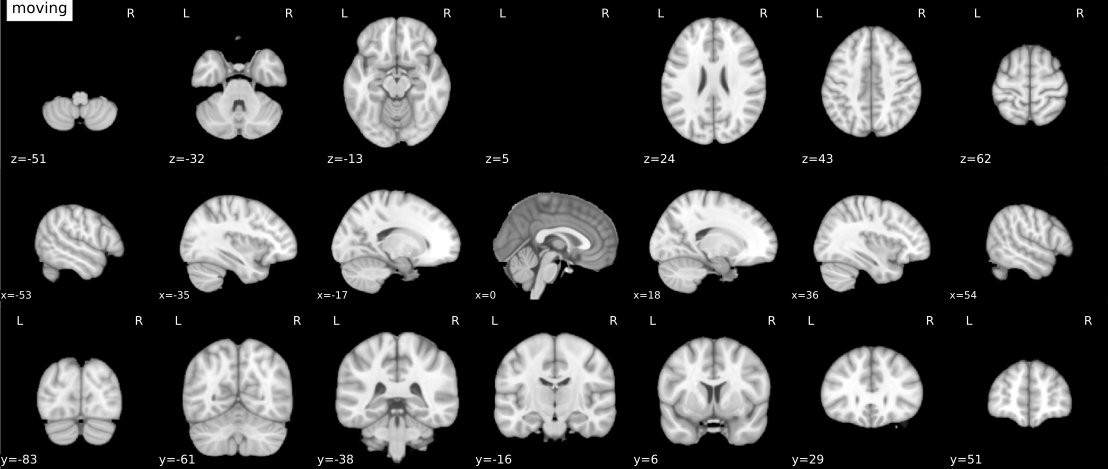

In [20]:
### Checkout registration quality
mni05_p4mm_2_mni05_1mm_svg = make_report(fixed_image=mni05_brain, 
                                         moving_image=syn_res2['transformed_source'],
                                         output_dir=registration_dir, fn='mni05_p4mm_2_mni05_1mm.svg')
from IPython.display import SVG, display
display(SVG(mni05_p4mm_2_mni05_1mm_svg))
### since this is basically a resample to a lower resolution, this is spot on

In [23]:
!ls masks/registration/

epi_space
mean-func_space-mni152.nii.gz
mni05_0p4_to_mni05_1p0_ants-def.nii.gz
mni05_0p4_to_mni05_1p0_ants-invmap.nii.gz
mni05_0p4_to_mni05_1p0_ants-map.nii.gz
mni05_1mm_2_mni09a.svg
mni05_1mm_2_mni09c.svg
mni05_p4mm_2_mni05_1mm.svg
mni05_p4mm_2_mni09a.svg
mni05_p4mm_2_mni09c.svg
mni05_to_mni09c_ants-def.nii.gz
mni05_to_mni09c_ants-invmap.nii.gz
mni05_to_mni09c_ants-map.nii.gz
MNI09a_2_1p6mm_ants-def.nii.gz
MNI09a_2_1p6mm_ants-invmap.nii.gz
MNI09a_2_1p6mm_ants-map.nii.gz
mni09a_2_1p6mm.svg
MNI152_T1_04mm_brain_ants-def.nii.gz
MNI152_T1_04mm_brain_ants-invmap.nii.gz
MNI152_T1_04mm_brain_ants-map.nii.gz
MNI152_T1_04mm_brain_def-img.nii.gz
MNI152_T1_1mm_brain_ants-def.nii.gz
MNI152_T1_1mm_brain_ants-invmap.nii.gz
MNI152_T1_1mm_brain_ants-map.nii.gz
tmp_report.svg


In [26]:
### Combine warps: MNI05 0.4mm -> MNI05 1mm -> 09a 1mm
# mapping1 = registration_dir + '/MNI152_T1_04mm_brain_ants-map.nii.gz'
# mapping2 = registration_dir + '/MNI152_T1_1mm_brain_ants-map.nii.gz'
mapping1 = os.path.join(registration_dir, 'mni05_0p4_to_mni05_1p0_ants-map.nii.gz')
mapping2 = os.path.join(registration_dir, 'mni05_to_mni09c_ants-map.nii.gz')

mni05_p4_to_mni09c = apply_coordinate_mappings(image=mni05_brain_p4mm,
                                               mapping1=mapping1,
                                               mapping2=mapping2, 
                                               save_data=True, 
                                               overwrite=True, 
                                               output_dir=registration_dir)


Apply coordinate mappings

Outputs will be saved to ./masks/registration/

Saving ./masks/registration/MNI152_T1_04mm_brain_def-img.nii.gz


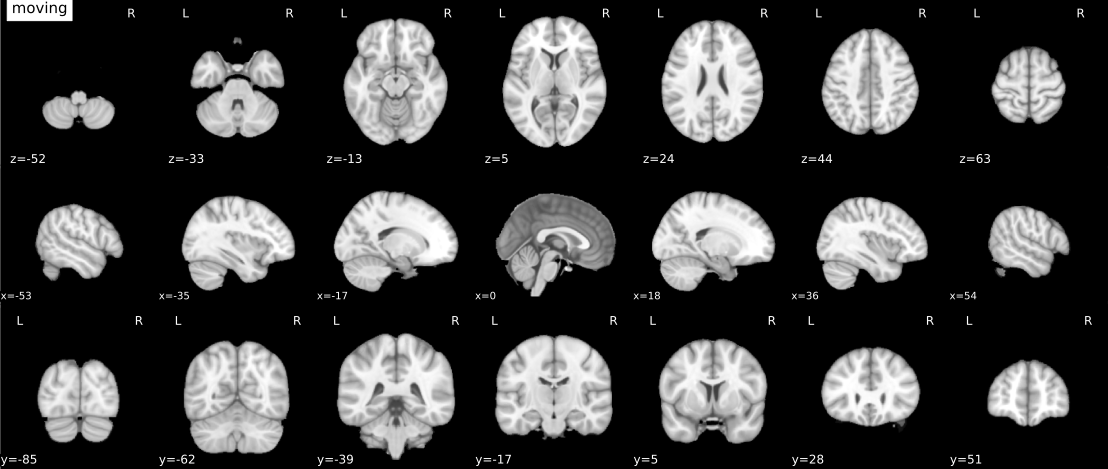

In [27]:
### Checkout registration quality
mni05_p4mm_2_mni09c_svg = make_report(fixed_image=mni09c_brain, moving_image=mni05_p4_to_mni09c['result'],
                                      output_dir=registration_dir, fn='mni05_p4mm_2_mni09c.svg')
from IPython.display import SVG, display
display(SVG(mni05_p4mm_2_mni09c_svg))

### Registration is fine

## 2. Get Harvard-Oxford ROIs

Harvard-Oxford probability are on scale 0-100, so divide all by 100

In [105]:
### Get Harvard-Oxford ROIs
from nilearn.datasets import fetch_atlas_harvard_oxford
ho_atlas = fetch_atlas_harvard_oxford(atlas_name='cort-prob-1mm')
ho_maps = nib.load(ho_atlas['maps'])

def get_slice(labels, name):
    slice_idx = [x for x, i in enumerate(labels) if i == name]
    return slice_idx[0] - 1

def get_atlas_img(atlas, slice_idx=0):
    dat = atlas.get_data()[:,:,:,slice_idx].astype(float)/100  # <--- rescales!
    img = nib.Nifti1Image(dat, atlas.affine)
    return img

def get_hemisphere(hdr, side='R'):
    if isinstance(hdr, str):
        hdr = nib.load(hdr)
    dat = hdr.get_data()
    
    if side == 'R':
        if hdr.affine[0,0] < 0: # right-left
            dat[int(dat.shape[0]/2):,:,:] = 0
        else:
            dat[:int(dat.shape[0]/2),:,:] = 0
    else:
        if hdr.affine[0,0] < 0: # right-left
            dat[:int(dat.shape[0]/2),:,:] = 0
        else:
            dat[int(dat.shape[0]/2):,:,:] = 0
    
    return nib.Nifti1Image(dat, hdr.affine)

#M1_prob_map = get_atlas_img(ho_maps, get_slice(ho_atlas.labels, 'Precentral Gyrus'))
#plotting.plot_roi(get_hemisphere(M1_prob_map, side='L'), bg_img=mni09a_brain)

#### 1. Anterior cingulate

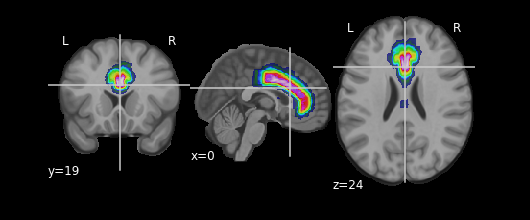

In [111]:
ho_maps = nib.load(ho_atlas['maps']) # reload to prevent in-place changes of already bound objects
ACC_prob_map = get_atlas_img(ho_maps, get_slice(ho_atlas.labels, 'Cingulate Gyrus, anterior division'))
plotting.plot_roi(ACC_prob_map, bg_img=mni09a_brain, threshold=0)

nib.save(ACC_prob_map, filename='./masks/original_harvard_oxford_mni05/ACC_prob_map.nii.gz')

#### 2. M1 / precentral gyrus

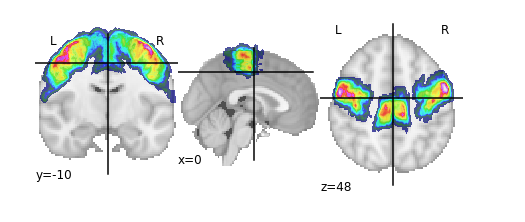

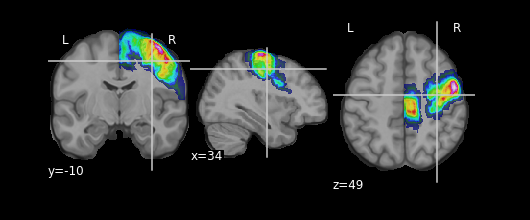

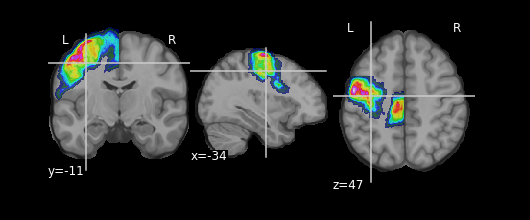

In [112]:
## M1 = Precentral Gyrus
ho_maps = nib.load(ho_atlas['maps']) # reload to prevent in-place changes of already bound objects
M1_prob_map = get_atlas_img(ho_maps, get_slice(ho_atlas.labels, 'Precentral Gyrus'))
plotting.plot_roi(M1_prob_map, threshold=0)
nib.save(M1_prob_map, filename='./masks/original_harvard_oxford_mni05/M1_prob_map.nii.gz')

# take right hemisphere only
ho_maps = nib.load(ho_atlas['maps']) # reload to prevent in-place changes of already bound objects
M1_R_prob_map = get_hemisphere(M1_prob_map, side='R')
plotting.plot_roi(M1_R_prob_map, bg_img=mni09a_brain, threshold=0)
nib.save(M1_R_prob_map, filename='./masks/original_harvard_oxford_mni05/M1_R_prob_map.nii.gz')

# left hemisphere
ho_maps = nib.load(ho_atlas['maps']) # reload to prevent in-place changes of already bound objects
M1_prob_map = get_atlas_img(ho_maps, get_slice(ho_atlas.labels, 'Precentral Gyrus'))
M1_L_prob_map = get_hemisphere(M1_prob_map, side='L')
plotting.plot_roi(M1_L_prob_map, bg_img=mni09a_brain, threshold=0)
nib.save(M1_L_prob_map, filename='./masks/original_harvard_oxford_mni05/M1_L_prob_map.nii.gz')

#### 3. (right) IFG

In [75]:
def sum_masks(mask1, mask2):
    dat = mask1.get_data() + mask2.get_data()
    img = nib.Nifti1Image(dat, mask1.affine)
    return img

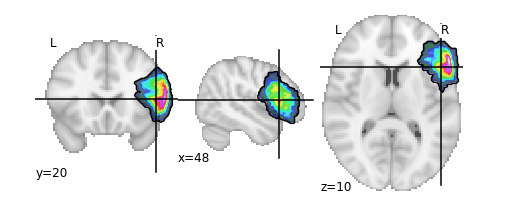

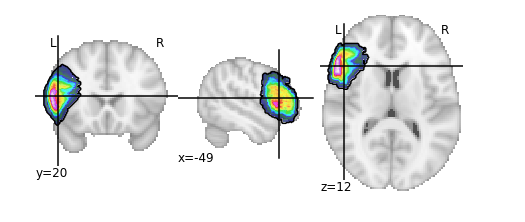

In [113]:
## rIFG: combine pars triangularis & pars opercularis in a single mask, then get right hemisphere
ho_maps = nib.load(ho_atlas['maps']) # reload to prevent in-place changes of already bound objects
IFG_pars_tr_prob_map = get_atlas_img(ho_maps, get_slice(ho_atlas.labels, 'Inferior Frontal Gyrus, pars triangularis'))
IFG_pars_op_prob_map = get_atlas_img(ho_maps, get_slice(ho_atlas.labels, 'Inferior Frontal Gyrus, pars opercularis'))
# plotting.plot_roi(get_atlas_img(ho_maps, get_slice(ho_atlas.labels, 'Inferior Frontal Gyrus, pars triangularis')), bg_img=mni09a_brain, threshold=0)
# plotting.plot_roi(get_atlas_img(ho_maps, get_slice(ho_atlas.labels, 'Inferior Frontal Gyrus, pars opercularis')), bg_img=mni09a_brain, threshold=0)

# make summed mask, both hemispheres
IFG_prob_map = sum_masks(IFG_pars_tr_prob_map, IFG_pars_op_prob_map)
nib.save(IFG_prob_map, filename='./masks/modified_from_harvard_oxford/IFG_prob_map.nii.gz')

# get & save right IFG only
rIFG_prob_map = get_hemisphere(IFG_prob_map, side='R')
disp = plotting.plot_roi(rIFG_prob_map, threshold=0, cut_coords=[48, 20, 10])
nib.save(rIFG_prob_map, filename='./masks/modified_from_harvard_oxford/IFG_R_prob_map.nii.gz')
add_contours(disp, './masks/modified_from_harvard_oxford/IFG_R_prob_map.nii.gz', thr=0, colors=['black'])



## rIFG: combine pars triangularis & pars opercularis in a single mask, then get right hemisphere
ho_maps = nib.load(ho_atlas['maps']) # reload to prevent in-place changes of already bound objects
IFG_pars_tr_prob_map = get_atlas_img(ho_maps, get_slice(ho_atlas.labels, 'Inferior Frontal Gyrus, pars triangularis'))
IFG_pars_op_prob_map = get_atlas_img(ho_maps, get_slice(ho_atlas.labels, 'Inferior Frontal Gyrus, pars opercularis'))
# make summed mask, both hemispheres
IFG_prob_map = sum_masks(IFG_pars_tr_prob_map, IFG_pars_op_prob_map)

# get & save left IFG only
lIFG_prob_map = get_hemisphere(IFG_prob_map, side='L')
disp = plotting.plot_roi(lIFG_prob_map, threshold=0)
nib.save(lIFG_prob_map, filename='./masks/modified_from_harvard_oxford/IFG_L_prob_map.nii.gz')
add_contours(disp, './masks/modified_from_harvard_oxford/IFG_L_prob_map.nii.gz', thr=0, colors=['black'])

### Apply warps to ROIs
##### 1. 05 -> 09a

In [121]:
roi_dict_mni05 = {
    'lSTR': './masks/ATAG_MNI04_1mm_space/Non-Linear/normalized/Nonlinear_MP2RAGE_STR_interrater_prop_L_normalized_1mm.nii.gz',
    'rSTR': './masks/ATAG_MNI04_1mm_space/Non-Linear/normalized/Nonlinear_MP2RAGE_STR_interrater_prop_R_normalized_1mm.nii.gz',
    'lSTN': './masks/ATAG_MNI04_1mm_space/Non-Linear/normalized/Nonlinear_FLASH_STh_interrater_prop_L_normalized_1mm.nii.gz',
    'rSTN': './masks/ATAG_MNI04_1mm_space/Non-Linear/normalized/Nonlinear_FLASH_STh_interrater_prop_R_normalized_1mm.nii.gz',
    'lPreSMA': './masks/orig_Boekel_et_al/03_PreSMA_L.nii.gz',
    'rPreSMA': './masks/orig_Boekel_et_al/04_PreSMA_R.nii.gz',
    'lGPi': './masks/ATAG_MNI04_1mm_space/Non-Linear/normalized/Nonlinear_QSM_GPi_interrater_prop_L_normalized_1mm.nii.gz',
    'rGPi': './masks/ATAG_MNI04_1mm_space/Non-Linear/normalized/Nonlinear_QSM_GPi_interrater_prop_R_normalized_1mm.nii.gz',
    'lGPe': './masks/ATAG_MNI04_1mm_space/Non-Linear/normalized/Nonlinear_QSM_GPe_interrater_prop_L_normalized_1mm.nii.gz',
    'rGPe': './masks/ATAG_MNI04_1mm_space/Non-Linear/normalized/Nonlinear_QSM_GPe_interrater_prop_R_normalized_1mm.nii.gz',
    'rIFG': './masks/modified_from_harvard_oxford/IFG_R_prob_map.nii.gz',
    'ACC': './masks/original_harvard_oxford_mni05/ACC_prob_map.nii.gz',
    'M1': './masks/original_harvard_oxford_mni05/M1_prob_map.nii.gz',
    'rM1': './masks/original_harvard_oxford_mni05/M1_R_prob_map.nii.gz',
    'lM1': './masks/original_harvard_oxford_mni05/M1_L_prob_map.nii.gz'
}

mapping1 = registration_dir + '/mni05_0p4_to_mni05_1p0_ants-map.nii.gz'
mapping2 = registration_dir + '/mni05_to_mni09c_ants-map.nii.gz'

redo = True
final_masks_mni09c_1mm = './masks/final_masks_mni09c_1mm'
if not os.path.exists(final_masks_mni09c_1mm):
    os.makedirs(final_masks_mni09c_1mm)

for mask, fn in roi_dict_mni05.items():
    if 'PreSMA' in mask:
        # two mappings
        apply_coordinate_mappings(fn, mapping1=mapping1, mapping2=mapping2, save_data=True, output_dir=final_masks_mni09c_1mm, file_name=mask,
                                  overwrite=redo)
    else:
        # single mapping
        apply_coordinate_mappings(fn, mapping1=mapping2, save_data=True, output_dir=final_masks_mni09c_1mm, file_name=mask,
                                  overwrite=redo)


Apply coordinate mappings

Outputs will be saved to ./masks/final_masks_mni09c_1mm/

Saving ./masks/final_masks_mni09c_1mm/lSTR_def-img.nii.gz

Apply coordinate mappings

Outputs will be saved to ./masks/final_masks_mni09c_1mm/

Saving ./masks/final_masks_mni09c_1mm/rSTR_def-img.nii.gz

Apply coordinate mappings

Outputs will be saved to ./masks/final_masks_mni09c_1mm/

Saving ./masks/final_masks_mni09c_1mm/lSTN_def-img.nii.gz

Apply coordinate mappings

Outputs will be saved to ./masks/final_masks_mni09c_1mm/

Saving ./masks/final_masks_mni09c_1mm/rSTN_def-img.nii.gz

Apply coordinate mappings

Outputs will be saved to ./masks/final_masks_mni09c_1mm/

Saving ./masks/final_masks_mni09c_1mm/lPreSMA_def-img.nii.gz

Apply coordinate mappings

Outputs will be saved to ./masks/final_masks_mni09c_1mm/

Saving ./masks/final_masks_mni09c_1mm/rPreSMA_def-img.nii.gz

Apply coordinate mappings

Outputs will be saved to ./masks/final_masks_mni09c_1mm/

Saving ./masks/final_masks_mni09c_1mm/lGPi_d

In [145]:
# rename to follow BIDS-convention(ish)
fns = glob.glob('./masks/final_masks_mni09c_1mm/*')
for fn in fns:
    if not 'space-' in fn:
        new_fn = fn.replace('_def-img', '_probseg').replace('1mm/', '1mm/space-MNI152NLin2009cAsym_label-')#.replace('_label', '_desc-1mm_label')
        os.rename(fn, new_fn)

In [146]:
fns = glob.glob('./masks/final_masks_mni09c_1mm/*')
fns

['./masks/final_masks_mni09c_1mm/space-MNI152NLin2009cAsym_label-ACC_probseg.nii.gz',
 './masks/final_masks_mni09c_1mm/space-MNI152NLin2009cAsym_label-lSTR_probseg.nii.gz',
 './masks/final_masks_mni09c_1mm/space-MNI152NLin2009cAsym_label-rM1_probseg.nii.gz',
 './masks/final_masks_mni09c_1mm/space-MNI152NLin2009cAsym_label-rGPe_probseg.nii.gz',
 './masks/final_masks_mni09c_1mm/space-MNI152NLin2009cAsym_label-lPreSMA_probseg.nii.gz',
 './masks/final_masks_mni09c_1mm/space-MNI152NLin2009cAsym_label-lSTN_probseg.nii.gz',
 './masks/final_masks_mni09c_1mm/space-MNI152NLin2009cAsym_label-lGPe_probseg.nii.gz',
 './masks/final_masks_mni09c_1mm/space-MNI152NLin2009cAsym_label-rSTN_probseg.nii.gz',
 './masks/final_masks_mni09c_1mm/space-MNI152NLin2009cAsym_label-rGPi_probseg.nii.gz',
 './masks/final_masks_mni09c_1mm/space-MNI152NLin2009cAsym_label-rIFG_probseg.nii.gz',
 './masks/final_masks_mni09c_1mm/space-MNI152NLin2009cAsym_label-lGPi_probseg.nii.gz',
 './masks/final_masks_mni09c_1mm/space-MNI

/home/stevenm/miniconda3/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/stevenm/miniconda3/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/stevenm/miniconda3/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/stevenm/miniconda3/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/stevenm/miniconda3/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/stevenm/miniconda3/lib/python

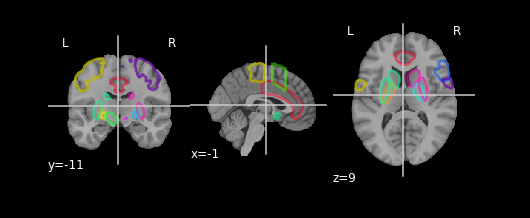

In [143]:
# make dict of masks & filenames in 09c-space
fns = glob.glob('./masks/final_masks_mni09c_1mm/*')
fns.sort()
names = [re.match('.*space-(?P<space>[a-zA-Z0-9]+)_label-(?P<label>[a-zA-Z0-9]+)_probseg.nii.gz', fn).groupdict()['label'] for fn in fns]
roi_dict_mni09c = dict(zip(names, fns))

# make nice plot
from nilearn import image
combined = image.concat_imgs(roi_dict_mni09c.values())
labels = dict(zip(np.arange(len(roi_dict_mni09c)), roi_dict_mni09c.keys()))
plotting.plot_prob_atlas(combined, bg_img=mni09c_brain, view_type='contours', threshold=0.3)

In [144]:
# load and check if truely probabilistic
for mask, fn in roi_dict_mni09c.items():
    max_val = nib.load(fn).get_data().max()
    print('Mask {}, max value: {}'.format(mask, max_val))

Mask ACC, max value: 1.0
Mask M1, max value: 0.9300000071525574
Mask lGPe, max value: 0.9863815903663635
Mask lGPi, max value: 0.9276273846626282
Mask lM1, max value: 0.9300000071525574
Mask lPreSMA, max value: 1.0
Mask lSTN, max value: 0.5079305768013
Mask lSTR, max value: 1.0
Mask rGPe, max value: 0.9930121898651123
Mask rGPi, max value: 0.9447857737541199
Mask rIFG, max value: 0.8999999761581421
Mask rM1, max value: 0.9100000262260437
Mask rPreSMA, max value: 1.0
Mask rSTN, max value: 0.5340195894241333
Mask rSTR, max value: 1.0


#### 2. MNI05 -> MNI09c 1p6mm (BOLD-resolution)

Select *any* BOLD-image (that was registered to MNI09c-space) and run embedded_syn without any iterations to resample in 1p6mm space


Embedded ANTs Registration

Outputs will be saved to ./masks/registration/

Saving ./masks/registration/mni09c_to_mni09c_1p6mm_tmp_srccoord.nii.gz

Saving ./masks/registration/mni09c_to_mni09c_1p6mm_tmp_trgcoord.nii.gz
registering /home/stevenm/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii
 to ./data/deriv/fmriprep/sub-01/ses-se/func/sub-01_ses-se_task-stop_run-1_space-MNI152NLin2009cAsym_boldref.nii.gz
antsRegistration --collapse-output-transforms 1 --dimensionality 3 --initialize-transforms-per-stage 0 --interpolation Linear --output mni09c_to_mni09c_1p6mm_tmp_syn --transform Rigid[ 0.1 ] --metric MI[ ./data/deriv/fmriprep/sub-01/ses-se/func/sub-01_ses-se_task-stop_run-1_space-MNI152NLin2009cAsym_boldref.nii.gz, /home/stevenm/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii, 1, 32, Random, 0.3 ] --convergence [ 0x0x0, 1e-06, 10 ] --smoothing-sigmas 3.0x2.0x1

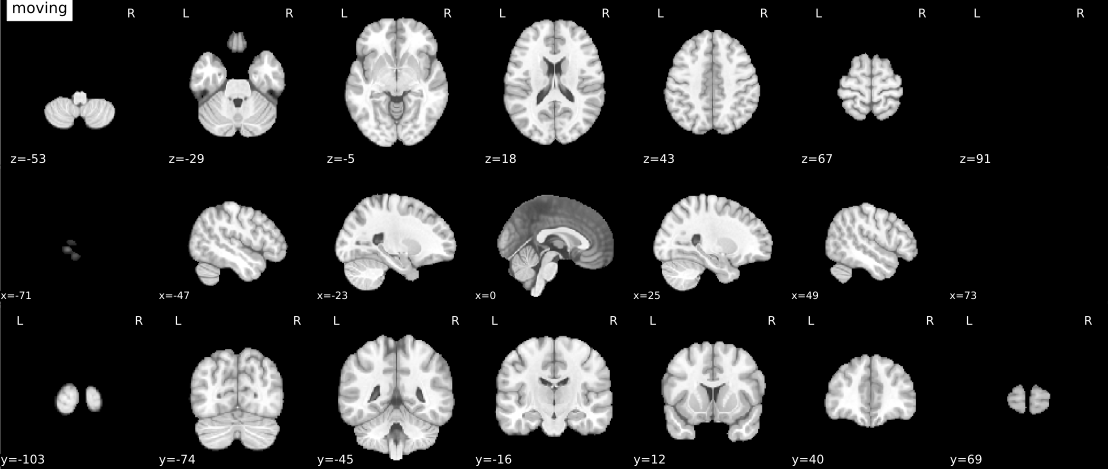

In [155]:
ref_bold = './data/deriv/fmriprep/sub-01/ses-se/func/sub-01_ses-se_task-stop_run-1_space-MNI152NLin2009cAsym_boldref.nii.gz'
syn_res = embedded_antsreg(source_image=mni09c_brain,
                           target_image=ref_bold,
                           rigid_iterations=0,
                           coarse_iterations=0,
                           medium_iterations=0,
                           fine_iterations=0,
                           run_rigid=True,
                           run_syn=False,
                           run_affine=False,
                           save_data=True,
                           output_dir=registration_dir,
                           file_name='mni09c_to_mni09c_1p6mm',
                           overwrite=False)

mni09c_2_1p6mm_svg = make_report(fixed_image=ref_bold, 
                                 moving_image='./masks/registration/mni09c_to_mni09c_1p6mm_ants-def.nii.gz', #syn_res['transformed_source'],
                                 output_dir=registration_dir, fn='mni09c_to_mni09c_1p6mm.svg')
from IPython.display import SVG, display
display(SVG(mni09c_2_1p6mm_svg))

In [158]:
### Apply transforms to each mask; save again
mapping1 = os.path.join(registration_dir, 'mni05_0p4_to_mni05_1p0_ants-map.nii.gz')
mapping2 = os.path.join(registration_dir, 'mni05_to_mni09c_ants-map.nii.gz')
mapping3 = os.path.join(registration_dir, 'mni09c_to_mni09c_1p6mm_ants-map.nii.gz')
# mapping_mni05_0p4_2_1mm = './masks/registration/MNI152_T1_04mm_brain_ants-map.nii.gz'
# mapping_mni05_1mm_2_mni09a = './masks/registration/MNI152_T1_1mm_brain_ants-map.nii.gz'
# mapping_mni09a_2_1p6mm = './masks/registration/MNI09a_2_1p6mm_ants-map.nii.gz'

final_masks_mni09c_1p6mm = './masks/final_masks_mni09c_1p6mm'
if not os.path.exists(final_masks_mni09c_1p6mm):
    os.makedirs(final_masks_mni09c_1p6mm)

redo=False
for mask, fn in roi_dict_mni05.items():
    if 'PreSMA' in mask:
        apply_coordinate_mappings(fn, 
                          mapping1=mapping1,      # 05 p4 -> 05 1mm
                          mapping2=mapping2,   # 05 -> 09a
                          mapping3=mapping3,       # 09a 1mm -> 09a 1.6mm
                          save_data=True, output_dir=final_masks_mni09c_1p6mm, file_name=mask,
                          overwrite=redo)
    else:
        apply_coordinate_mappings(fn, 
                                  mapping1=mapping2,   # 05 -> 09a
                                  mapping2=mapping3,       # 09a -> 09a 1.6mm
                                  save_data=True, output_dir=final_masks_mni09c_1p6mm, file_name=mask,
                                  overwrite=redo)


Apply coordinate mappings

Outputs will be saved to ./masks/final_masks_mni09c_1p6mm/

Saving ./masks/final_masks_mni09c_1p6mm/lSTR_def-img.nii.gz

Apply coordinate mappings

Outputs will be saved to ./masks/final_masks_mni09c_1p6mm/

Saving ./masks/final_masks_mni09c_1p6mm/rSTR_def-img.nii.gz

Apply coordinate mappings

Outputs will be saved to ./masks/final_masks_mni09c_1p6mm/

Saving ./masks/final_masks_mni09c_1p6mm/lSTN_def-img.nii.gz

Apply coordinate mappings

Outputs will be saved to ./masks/final_masks_mni09c_1p6mm/

Saving ./masks/final_masks_mni09c_1p6mm/rSTN_def-img.nii.gz

Apply coordinate mappings

Outputs will be saved to ./masks/final_masks_mni09c_1p6mm/

Saving ./masks/final_masks_mni09c_1p6mm/lPreSMA_def-img.nii.gz

Apply coordinate mappings

Outputs will be saved to ./masks/final_masks_mni09c_1p6mm/

Saving ./masks/final_masks_mni09c_1p6mm/rPreSMA_def-img.nii.gz

Apply coordinate mappings

Outputs will be saved to ./masks/final_masks_mni09c_1p6mm/

Saving ./masks/fin

In [159]:
# rename to follow BIDS-convention(ish)
fns = glob.glob('./masks/final_masks_mni09c_1p6mm/*')
for fn in fns:
    if not 'space-' in fn:
        new_fn = fn.replace('_def-img', '_probseg').replace('1p6mm/', '1p6mm/space-MNI152NLin2009cAsym_label-')#.replace('_label', '_desc-1mm_label')
        os.rename(fn, new_fn)

In [160]:
fns = glob.glob('./masks/final_masks_mni09c_1p6mm/*')
fns

['./masks/final_masks_mni09c_1p6mm/space-MNI152NLin2009cAsym_label-ACC_probseg.nii.gz',
 './masks/final_masks_mni09c_1p6mm/space-MNI152NLin2009cAsym_label-lSTR_probseg.nii.gz',
 './masks/final_masks_mni09c_1p6mm/space-MNI152NLin2009cAsym_label-rM1_probseg.nii.gz',
 './masks/final_masks_mni09c_1p6mm/space-MNI152NLin2009cAsym_label-rGPe_probseg.nii.gz',
 './masks/final_masks_mni09c_1p6mm/space-MNI152NLin2009cAsym_label-lPreSMA_probseg.nii.gz',
 './masks/final_masks_mni09c_1p6mm/space-MNI152NLin2009cAsym_label-lSTN_probseg.nii.gz',
 './masks/final_masks_mni09c_1p6mm/space-MNI152NLin2009cAsym_label-lGPe_probseg.nii.gz',
 './masks/final_masks_mni09c_1p6mm/space-MNI152NLin2009cAsym_label-rSTN_probseg.nii.gz',
 './masks/final_masks_mni09c_1p6mm/space-MNI152NLin2009cAsym_label-rGPi_probseg.nii.gz',
 './masks/final_masks_mni09c_1p6mm/space-MNI152NLin2009cAsym_label-rIFG_probseg.nii.gz',
 './masks/final_masks_mni09c_1p6mm/space-MNI152NLin2009cAsym_label-lGPi_probseg.nii.gz',
 './masks/final_mask

/home/stevenm/miniconda3/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/stevenm/miniconda3/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/stevenm/miniconda3/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/stevenm/miniconda3/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/stevenm/miniconda3/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/stevenm/miniconda3/lib/python

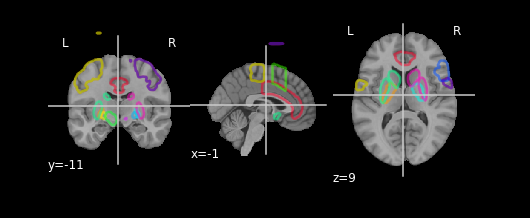

In [161]:
# make dict of masks & filenames in 09c-space
fns = glob.glob('./masks/final_masks_mni09c_1p6mm/*')
fns.sort()
names = [re.match('.*space-(?P<space>[a-zA-Z0-9]+)_label-(?P<label>[a-zA-Z0-9]+)_probseg.nii.gz', fn).groupdict()['label'] for fn in fns]
roi_dict_mni09c_1p6mm = dict(zip(names, fns))

# make nice plot
from nilearn import image
combined = image.concat_imgs(roi_dict_mni09c_1p6mm.values())
labels = dict(zip(np.arange(len(roi_dict_mni09c_1p6mm)), roi_dict_mni09c_1p6mm.keys()))
plotting.plot_prob_atlas(combined, bg_img=mni09c_brain, view_type='contours', threshold=0.3)

Some masks are in a weird place, but this is a plotting artefact

Max value: 1.000
Max value: 0.930
Max value: 0.983
Max value: 0.902
Max value: 0.930
Max value: 1.000


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/plotting/displays.py:684: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
/home/stevenm/miniconda3/lib/python3.7/site-packages/numpy/ma/core.py:2785: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/home/stevenm/miniconda3/lib/python3.7/site-packages/numpy/ma/core.py:2785: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/home/stevenm/miniconda3/lib/python3.7/site-packages/numpy/ma/core.py:2785: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/home/stevenm/miniconda3/lib/python3.7/site-packages/numpy/ma/core.py:2785: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/home/stevenm/miniconda3/lib/python3.7/site-packages/numpy/ma/core.py:2785: UserWarning: Warning: converting a masked element to nan.
  or

Max value: 0.490
Max value: 1.000
Max value: 0.993
Max value: 0.920
Max value: 0.900
Max value: 0.910
Max value: 1.000


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/plotting/displays.py:684: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
/home/stevenm/miniconda3/lib/python3.7/site-packages/numpy/ma/core.py:2785: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/home/stevenm/miniconda3/lib/python3.7/site-packages/numpy/ma/core.py:2785: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/home/stevenm/miniconda3/lib/python3.7/site-packages/numpy/ma/core.py:2785: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/home/stevenm/miniconda3/lib/python3.7/site-packages/numpy/ma/core.py:2785: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/home/stevenm/miniconda3/lib/python3.7/site-packages/numpy/ma/core.py:2785: UserWarning: Warning: converting a masked element to nan.
  or

Max value: 0.498
Max value: 1.000


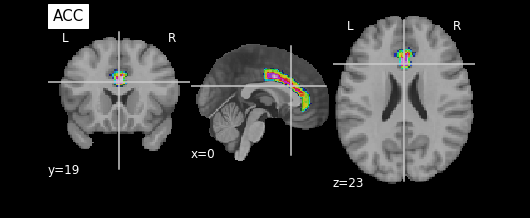

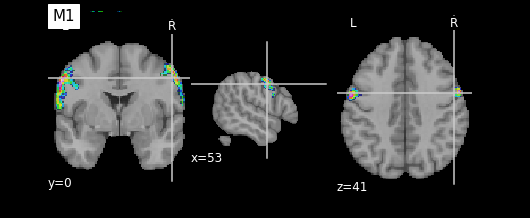

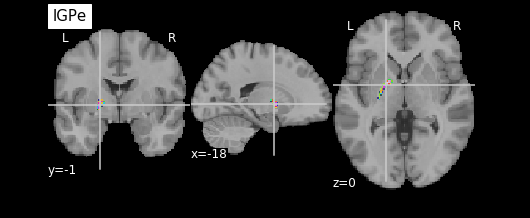

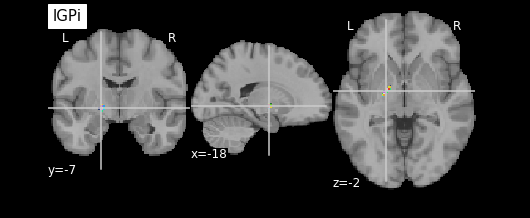

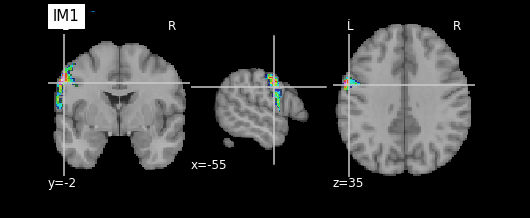

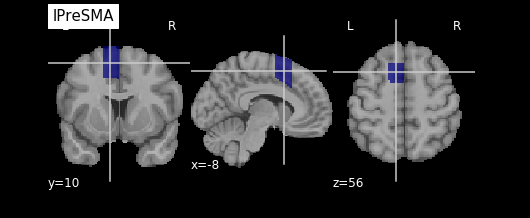

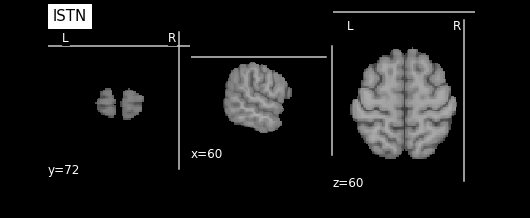

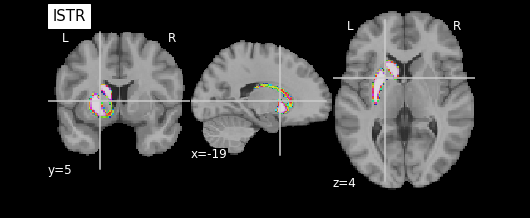

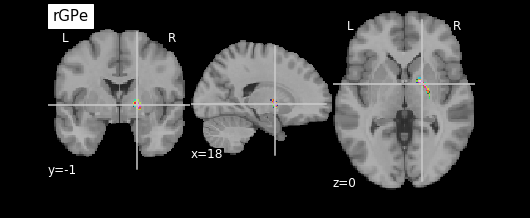

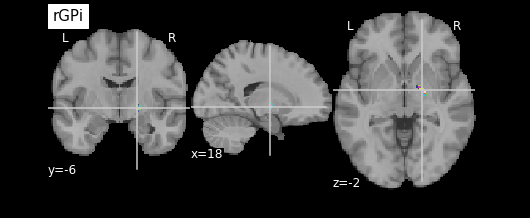

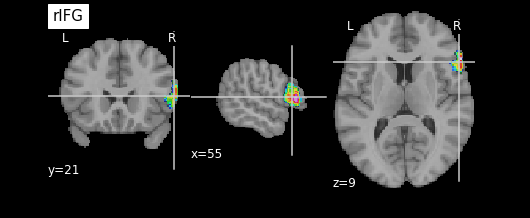

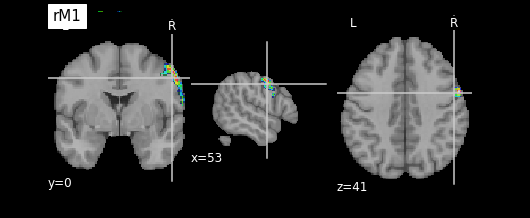

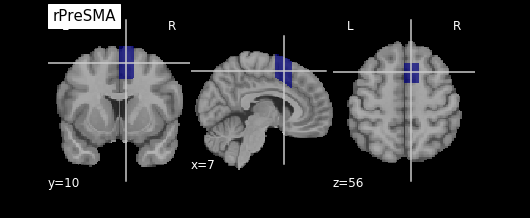

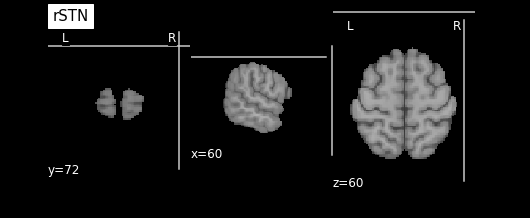

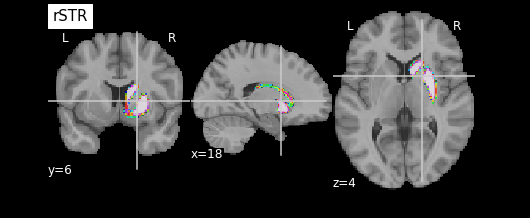

In [163]:
for mask, fn in roi_dict_mni09c_1p6mm.items():
    _ = plotting.plot_roi(fn, bg_img = './masks/registration/mni09c_to_mni09c_1p6mm_ants-def.nii.gz', title=mask)
    print('Max value: %.3f' %nib.load(fn).get_data().max())

/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/plotting/displays.py:684: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


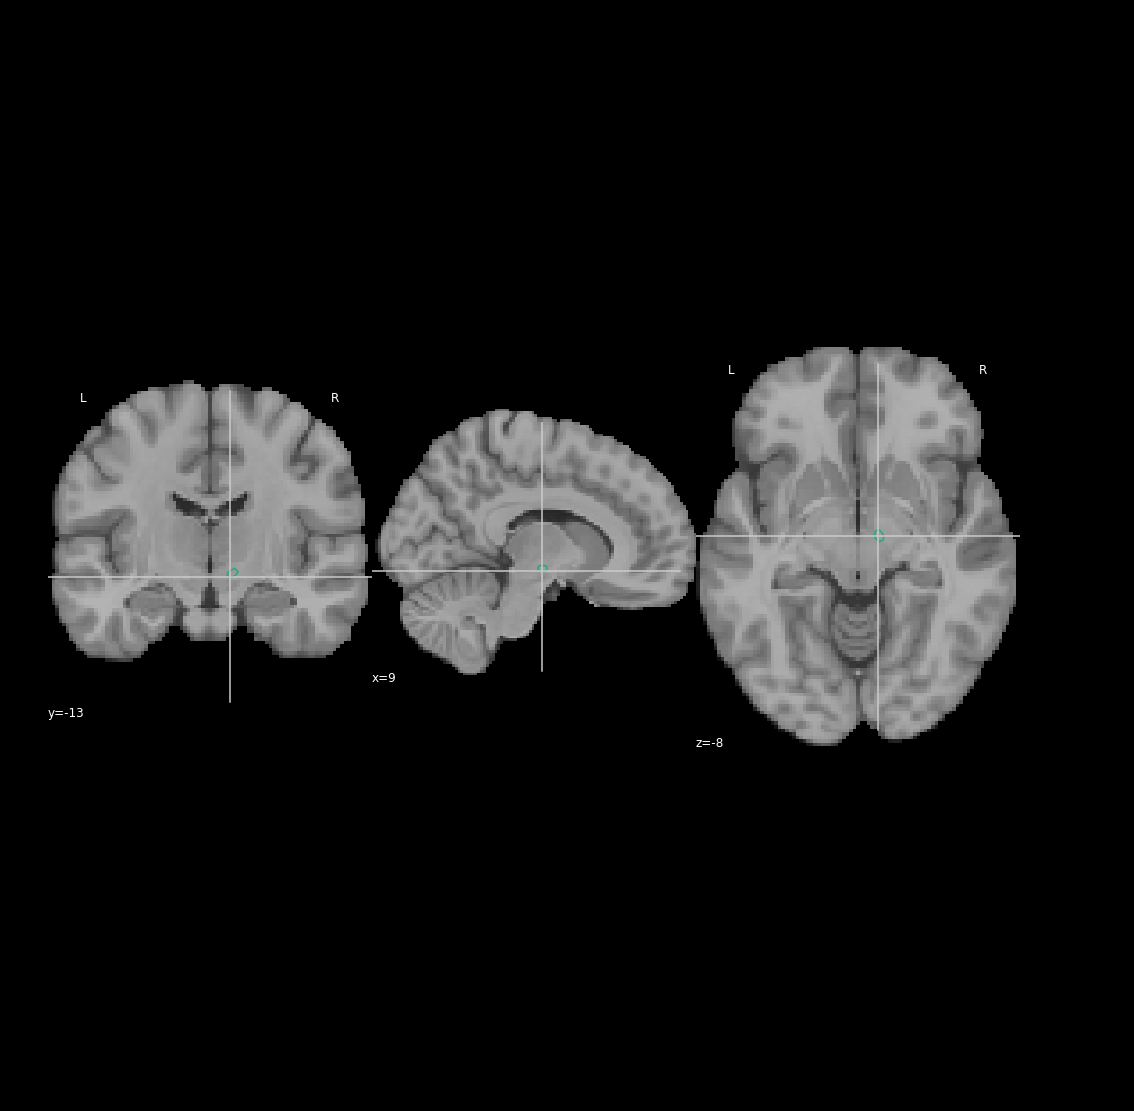

In [178]:
disp = plotting.plot_roi(roi_dict_mni09c_1p6mm['rSTN'], 
                         bg_img=registration_dir + '/MNI09c_2_1p6mm_ants-def.nii.gz',
                         vmin=0.01, vmax=0.1, cut_coords=[9, -13, -8])#, vmin=0, vmax=0.3)
add_contours(disp, roi_dict_mni09c_1p6mm['rSTN'])
plt.gcf().set_size_inches(15,15)

/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/plotting/displays.py:684: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


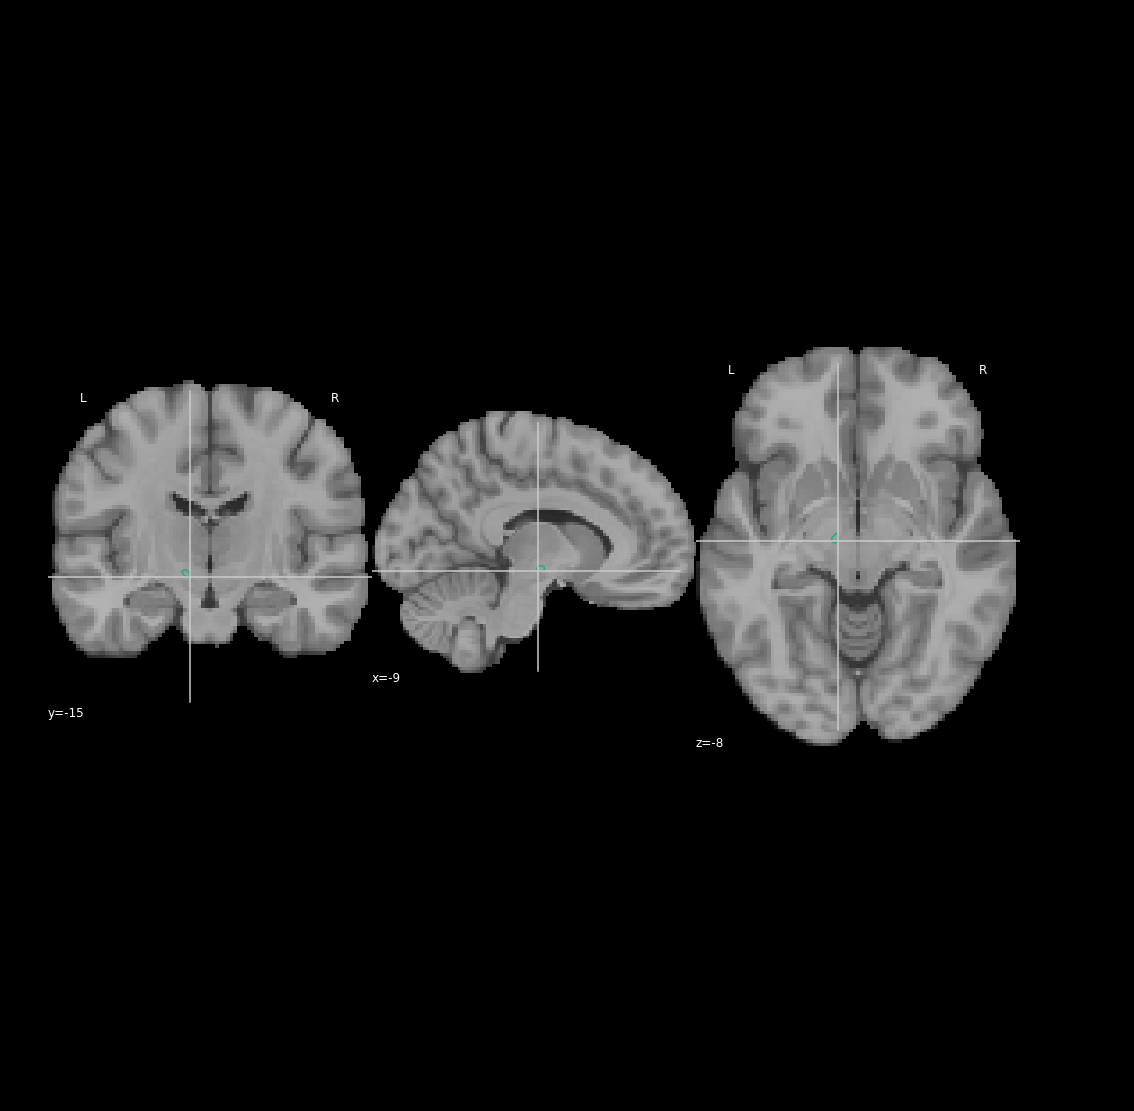

In [179]:
disp = plotting.plot_roi(roi_dict_mni09c_1p6mm['lSTN'], bg_img=registration_dir + '/MNI09c_2_1p6mm_ants-def.nii.gz',
                         vmin=0.01, vmax=0.1, cut_coords=[-9, -15, -8])#, vmin=0, vmax=0.3)
add_contours(disp, roi_dict_mni09c_1p6mm['lSTN'])
plt.gcf().set_size_inches(15,15)

In [180]:
plotting.plot_roi(roi_dict_mni09a['STN_R'], bg_img=mni09a_brain)

NameError: name 'roi_dict_mni09a' is not defined